# **Naive models vs. neural networks in forecasting**

Naive models of time series (e.g., see [here](https://otexts.com/fpp2/simple-methods.html)) provide useful benchmarks to judge the test set performance of autoregressive models. They help reveal the actual gain of using more complex model types/architectures, and do so by showing how good an deliberately simple model would be if used on the available data. 

The logic behind this is - if a very simple model does only slightly worse than a more sophisticated one, the latter is probably not justified. For example, if a naive model as simple as $x(t) = x(t-1)$ has a test set error that's only, say, 5% worse than that of a neural network with hundreds or thousands of parameters, there's really no reason to incur the cost of that complexity, i.e., our modelling approach would not be _**parsimonious**_ (apart from the obvious overfitting risk). 

What's more interesting is that, in practice, it's often the case that naive models perform surprisingly well compared to more complex approaches, especially in data-limited contexts. In such situations, any neural networks (LSTMs, convolutional models) we train can have but a few parameters/layers in order to avoid overfitting, and with such parameter- and data-limitations these architectures cannot realize their potential, limiting any gains in performance afforded by their complexity.  

This notebook illustrates this situation with synthetic data.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import (
    split_and_standarize_data,
    WindowGenerator, compile_and_fit, make_ypred
)

Let's start by building two synthetic datasets based on an seasonal autoregressive process - a small one, with just a couple of thousand datapoints, and a big dataset with >100k observations

In [25]:
def make_autoregressive_series(n):

    sigma = 10. # variance of noise term
    delta = 0. # drift
    phi1 = 0.75 # 1st-order autoregression coefficient
    w = np.random.normal(loc=0, scale=2, size=n) # noise vector
    t = np.arange(n) # time vector
    x = np.zeros(n, float) # initialize series
    T1, T2, T3 = 100000, 5000, 500 # periods of seasonal components
    s1, s2, s3 = np.sin(2.*np.pi/T1*t), np.sin(2.*np.pi/T2*t), np.sin(2*np.pi/T3*t)
    x[0] = 0.0 # first value of series

    # build series
    for i in range(1, n, 1):
        x[i] = delta + phi1*x[i-1] + + s1[i] + s2[i] + s3[i] + w[i]
    
    x = pd.DataFrame(x, index=t, columns=['x'])

    return x

train: (2400, 1)
val: (800, 1)
test: (800, 1)


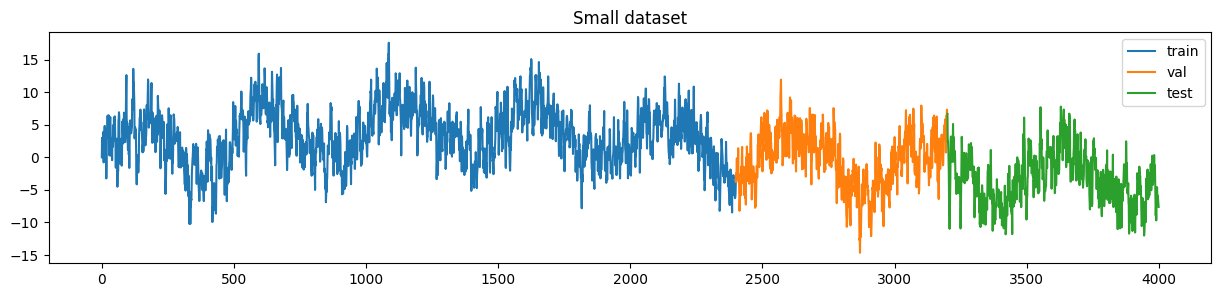

In [26]:
x_small = make_autoregressive_series(n=4000)

x_small_datasets = split_and_standarize_data(x_small, f_train=0.6, f_val=0.2)

fig = plt.figure(figsize=(15, 3))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[:,:])
ax.plot(x_small_datasets['train_timestamps'], x_small_datasets['train_df_original']['x'], label='train')
ax.plot(x_small_datasets['val_timestamps'], x_small_datasets['val_df_original']['x'], label='val')
ax.plot(x_small_datasets['test_timestamps'], x_small_datasets['test_df_original']['x'], label='test')
ax.legend()
ax.set_title('Small dataset')
plt.show()

train: (150000, 1)
val: (50000, 1)
test: (50000, 1)


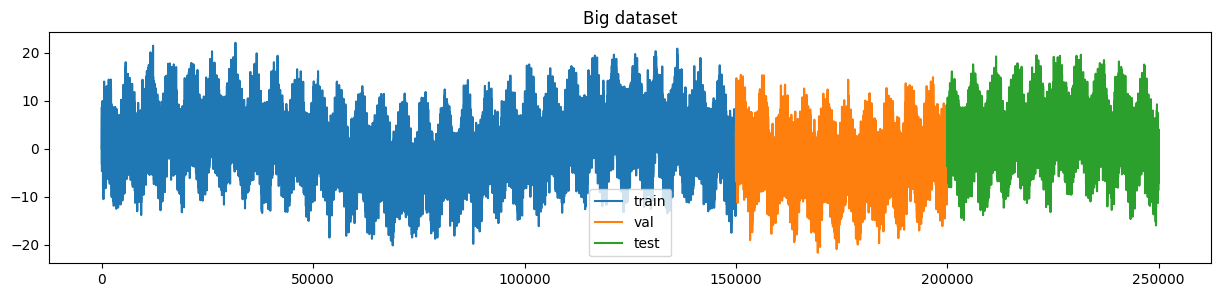

In [30]:
x_small = make_autoregressive_series(n=250000)

x_small_datasets = split_and_standarize_data(x_small, f_train=0.6, f_val=0.2)

fig = plt.figure(figsize=(15, 3))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[:,:])
ax.plot(x_small_datasets['train_timestamps'], x_small_datasets['train_df_original']['x'], label='train')
ax.plot(x_small_datasets['val_timestamps'], x_small_datasets['val_df_original']['x'], label='val')
ax.plot(x_small_datasets['test_timestamps'], x_small_datasets['test_df_original']['x'], label='test')
ax.legend()
ax.set_title('Big dataset')
plt.show()

In [ ]:



BATCH_SIZE = 32
MAX_EPOCHS = 100
CONV_WIDTH = 10
LABEL_WIDTH = 1
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

conv_bigdata = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=2, kernel_size=(CONV_WIDTH,)),
    tf.keras.layers.Dense(units=1),
])

w_conv_bigdata = WindowGenerator(
    input_width=INPUT_WIDTH, 
    label_width=LABEL_WIDTH, 
    offset=1, 
    train_df=big_datasets['train_df'],
    val_df=big_datasets['val_df'],
    test_df=big_datasets['test_df'],
    batch_size=BATCH_SIZE,
    label_columns=['x'])

print(f'X shape = {w_conv_bigdata.example[0].shape}')
print(f'y_pred shape = {conv_bigdata(w_conv_bigdata.example[0]).shape}')
print(f'y_obs shape = {w_conv_bigdata.example[1].shape}')

conv_bigdata(w_conv_bigdata.example[0]) # build model to get number of parameters

print(f'Estimating {conv_bigdata.count_params():,} parameters on {w_conv_bigdata.train_df.shape[0]:,} datapoints')

In [ ]:

history_conv_bigdata = compile_and_fit(conv_bigdata, w_conv_bigdata, max_epochs=MAX_EPOCHS, patience=20, verbose=1)

ypred_conv_bigdata = make_ypred(conv_bigdata, w_conv_bigdata, big_datasets['train_mean']['x'], big_datasets['train_sd']['x'])

fig, ax = plt.subplots()
ax.plot(history_conv_bigdata.history['loss'], label='train')
ax.plot(history_conv_bigdata.history['val_loss'], label='val')
ax.legend()
plt.show()


ypred['conv_bigdata'] = ypred_conv_bigdata
err_rel['conv_bigdata'] = 100. * (ypred['conv_bigdata'] - big_datasets['test_df_original']['x']) / big_datasets['test_df_original']['x']
err_abs['conv_bigdata'] = ypred['conv_bigdata'] - big_datasets['test_df_original']['x']

# add ypred for naive big data baseline model
ypred_naive_bigdata = big_datasets['test_df_original']['x'][:-1].values
ytest_naive_bigdata = big_datasets['test_df_original']['x'][1:].values
ypred['naive_bigdata'] = ypred_naive_bigdata
err_rel['naive_bigdata'] = 100. * (ypred['naive_bigdata'] - ytest_naive_bigdata)/ytest_naive_bigdata
err_abs['naive_bigdata'] = ypred['naive_bigdata'] - ytest_naive_bigdata

bins = np.arange(-300, 305, 5)
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(2, 4)

ax1 = fig.add_subplot(gs[:, :3])
ax1.plot(big_datasets['test_timestamps'], big_datasets['test_df_original']['x'], linewidth=1, color='black', label='y_test')
ax1.plot(big_datasets['test_timestamps'], ypred_conv_bigdata, linewidth=1, color='red', alpha=0.5, label=f'conv1d')
ax1.set_xlim(280000, 280400)
ax1.legend(loc=1)
ax2 = fig.add_subplot(gs[0, 3:])
ax2.set_title('Naive big data')
ax2.hist(err_rel['naive_bigdata'], bins=bins, density=True)
ax3 = fig.add_subplot(gs[1, 3:])
ax3.set_title('Conv1D big data')
ax3.hist(err_rel['conv_bigdata'], bins=bins, density=True)
plt.tight_layout()
plt.show()

perc_rel_errors_below_10['naive_bigdata'] = 100.*err_rel['naive_bigdata'][err_rel['naive_bigdata'] <= 10].size/err_rel['naive_bigdata'].size
perc_rel_errors_below_10['conv_bigdata'] = 100.*err_rel['conv_bigdata'][err_rel['conv_bigdata'] <= 10].size/err_rel['conv_bigdata'].size

print(perc_rel_errors_below_10['naive_bigdata'])
print(perc_rel_errors_below_10['conv_bigdata'])
